In [1]:
n_fold= 1
total_fold= '5'
use_enchanced_dataset= False
model_name= "T3"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from tqdm.notebook import tqdm
import os

# Keras
import tensorflow as tf
# import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, model_from_json, load_model
# from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from keras import backend as K
from callback import MultipleClassAUROC
#from keras.applications.densenet import DenseNet121

import util
from sklearn.metrics import confusion_matrix, classification_report
from livelossplot import PlotLossesKeras
from keras.initializers import RandomNormal
from swintransformer import SwinTransformer

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

print("Test built: {}".format(tf.test.is_built_with_cuda()))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Test built: True


In [4]:
if use_enchanced_dataset == True:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/enchanced/"
else:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/original/images/"
    
train_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "train_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]
test_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "test_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]

labels = ['No Findings',
          'Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

print("Leakage between train and test: {}".format(util.check_for_leakage(train_df, test_df, 'Image Index')))

Leakage between train and test: False


In [5]:
# Setting
seed= 1
batch_size= 32
# target_w= 320; target_h= 320; dim= (3,)
target_w= 224; target_h= 224; dim= (3,)
image_size_target= (target_w,target_h)
image_shape= image_size_target + dim
class_mode= 'raw'   # raw, categorical 

use_aug= False
use_normalize= True
index_col= "Image Index"
labels_col= labels

def prepare_generator(use_Aug, use_Normalize):
    # == Aug Image
    if use_Aug== True and use_Normalize== False:
        return ImageDataGenerator(
            rescale= 1./255,        
            horizontal_flip= True,
            height_shift_range= 0.5,
            width_shift_range= 0.5,
            vertical_flip= True,
            rotation_range= 20,
            fill_mode= "nearest"
            )
    # == Normalize Image
    if use_Aug== False and use_Normalize== True:
        return ImageDataGenerator(
            rescale= 1./255,
            horizontal_flip= True,
            samplewise_center= True,
            samplewise_std_normalization= True
            )
    # == Without
    if use_Aug== False and use_Normalize== False:
        return ImageDataGenerator()

============ getting train generator ===========
Found 4484 validated image filenames.

==== getting train and test/valid generators ====
Found 4484 validated image filenames.
Found 1122 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


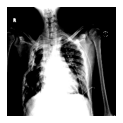

In [6]:
# === Image Train Generator
print("============ getting train generator ===========") 
image_train= prepare_generator(use_Aug=False, use_Normalize=True).flow_from_dataframe(
    dataframe= train_df,
    directory= IMAGE_DIR,
    x_col= index_col,
    y_col= labels,
    class_mode= class_mode,
    batch_size= batch_size,
    shuffle= True,
    target_size= image_size_target
)

# === Image Validation and Test Generator
print("")
print("==== getting train and test/valid generators ====")
raw_train_generator= prepare_generator(False, False).flow_from_dataframe(
                        dataframe= train_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= True,
                        target_size= image_size_target
                    )
batch= raw_train_generator.next()
data_sample= batch[0]
imagegenerator= prepare_generator(False, True)
imagegenerator.fit(data_sample)
image_val = imagegenerator.flow_from_dataframe(
                        dataframe= test_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= False,
                        target_size= image_size_target
                    )

x, y = image_train.__getitem__(0)
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(x[0]);

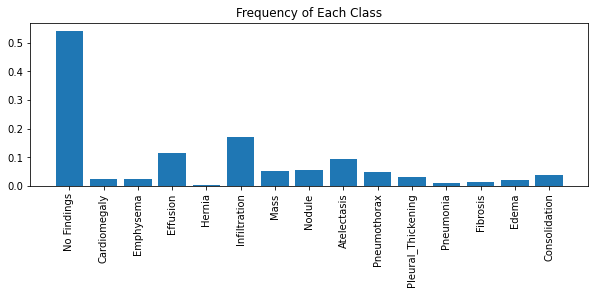

In [7]:
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(image_train.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [8]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(image_train.labels)
freq_pos

array([0.54192685, 0.02520071, 0.02363961, 0.11641392, 0.00223015,
       0.17105263, 0.05307761, 0.0544157 , 0.0941124 , 0.04772525,
       0.03077609, 0.01137377, 0.01449599, 0.02118644, 0.0396967 ])

<ipython-input-9-5b7fdcf061fc>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


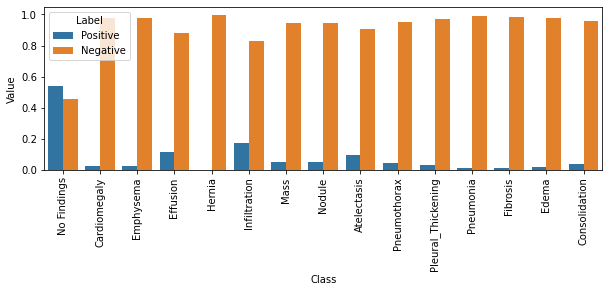

In [9]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

<ipython-input-10-705df616134b>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


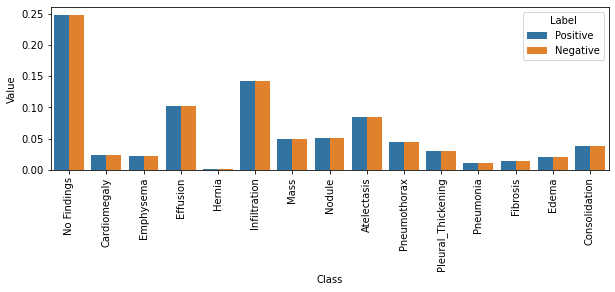

In [10]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [11]:
class_weights = util.generate_class_weights(image_train.labels, multi_class=False, one_hot_encoded=True)

In [12]:
class_weights

{0: 0.12301783264746227,
 1: 2.6454277286135692,
 2: 2.820125786163522,
 3: 0.572669220945083,
 4: 29.893333333333334,
 5: 0.38974358974358975,
 6: 1.2560224089635854,
 7: 1.2251366120218579,
 8: 0.7083728278041074,
 9: 1.3968847352024922,
 10: 2.166183574879227,
 11: 5.861437908496732,
 12: 4.598974358974359,
 13: 3.1466666666666665,
 14: 1.6794007490636704}

In [13]:
image_shape

(224, 224, 3)

In [14]:
inputs= Input(shape=image_shape)
# inputs= image_shape
# inputs

In [15]:
num_class = len(labels)

In [16]:
def mlp_head(x, depth=[128, 128], dropout_rate=0.5):
    for units in depth:
        x = layers.Dense(units, activation='LeakyReLU')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        # x = Flatten()(x)
    return x

In [17]:
inputs= Input(shape=(224,224,3))

In [18]:
mdl1 = hub.KerasLayer("https://tfhub.dev/sayakpaul/swin_s3_tiny_224_fe/1", trainable=False)(inputs)
# swin_output = Flatten()(swin_output)

mdl1 = Model(inputs, mdl1)
mdl1.trainable = False

mdl2 = tf.keras.applications.MobileNetV3Large(weights='imagenet', 
                                                      alpha=1.0, 
                                                      include_top=False)(inputs)

outputs = GlobalMaxPooling2D()(mdl2)
mdl2 = Model(inputs=inputs, outputs=outputs)
mdl2.trainable = False

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [19]:
fusion = Concatenate()([mdl1.output, mdl2.output])
fusion = BatchNormalization()(fusion)

aux1 = mlp_head(mdl1.output, depth=[1024, 512])

aux2 = mlp_head(mdl2.output, depth=[1024, 512])

main = mlp_head(fusion, depth=[2048, 1024])

head = Concatenate()([aux1, main, aux2])
head = mlp_head(head, depth=[4096, 2048, 512, 256])

predictions = Dense(num_class, activation="sigmoid")(head)

model = Model(inputs=inputs, outputs=predictions)

In [20]:
output_dir = './output_weights/{}'.format(model_name)
weight_path = '{}_ckp_weights.h5'.format(model_name)

output_weights_path = os.path.join(output_dir, weight_path)

if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

auroc = MultipleClassAUROC(
            sequence=image_val,
            class_names=labels,
            weights_path=output_weights_path,
            workers=1,
        )

In [21]:
epoch = 25

lr = 0.001
decay_rate = lr / epoch
momentum = 0.99
# adam = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=decay_rate, beta_2=decay_rate*decay_rate, epsilon=1e-07, amsgrad=False)
sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=False)
checkpoint = ModelCheckpoint(output_weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

# class_weigths = dict(zip(range(len(neg_weights)), neg_weights))
# weighted_loss = get_weighted_loss(pos_weights, neg_weights)
bce_ls = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)

metric_auc = tf.keras.metrics.AUC(multi_label=True)

model.compile(loss=bce_ls, optimizer=sgd, metrics=[metric_auc])

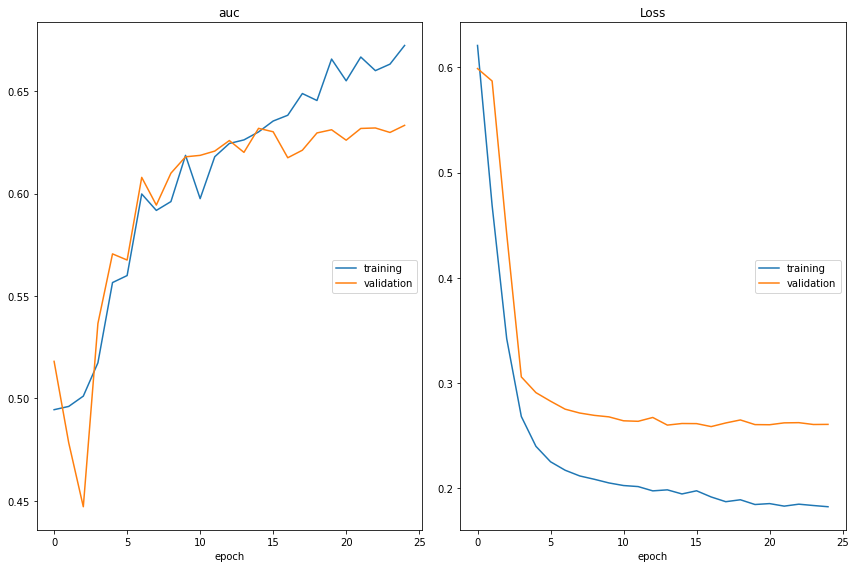

auc
	training         	 (min:    0.495, max:    0.672, cur:    0.672)
	validation       	 (min:    0.447, max:    0.633, cur:    0.633)
Loss
	training         	 (min:    0.182, max:    0.621, cur:    0.182)
	validation       	 (min:    0.259, max:    0.599, cur:    0.261)

*********************************
current learning rate: 0.0010000000474974513


/home/cries/Workshop/X-Ray/TransX-Ray/jeremie/callback.py:58: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_hat = self.model.predict_generator(self.sequence, workers=self.workers)


*** epoch#25 dev auroc ***
1. No Findings: 0.6750012824129883
2. Cardiomegaly: 0.6804322277357011
3. Emphysema: 0.77751827343108
4. Effusion: 0.6754918032786886
5. Hernia: 0.42627345844504017
6. Infiltration: 0.5720498915401302
7. Mass: 0.5088087926297076
8. Nodule: 0.553277729606232
9. Atelectasis: 0.6369421747328723
10. Pneumothorax: 0.6860060950498311
11. Pleural_Thickening: 0.5338172460671975
12. Pneumonia: 0.6716307994435807
13. Fibrosis: 0.5554707257718184
14. Edema: 0.807809471060648
15. Consolidation: 0.74129034761018
*********************************
mean auroc: 0.6334546879210465
141/141 [==============================] - 106s 749ms/step - loss: 0.1824 - auc: 0.6723 - val_loss: 0.2607 - val_auc: 0.6333


In [22]:
start = time.time() 
history = model.fit(image_train, epochs=epoch, validation_data=image_val, callbacks=[checkpoint,PlotLossesKeras(), auroc],verbose=1, class_weight=class_weights)
end_train = time.time() - start

In [23]:
save_model_path = os.path.join(output_dir, 'model_{}'.format(model_name))
model.save(save_model_path)

INFO:tensorflow:Assets written to: ./output_weights/T3/model_T3/assets


INFO:tensorflow:Assets written to: ./output_weights/T3/model_T3/assets


In [24]:
final_weight_model_path = os.path.join(output_dir, '{}_weights.h5'.format(model_name))
model.save_weights(final_weight_model_path)
file_stats = os.stat(final_weight_model_path)
model_size = round(file_stats.st_size / (1024 * 1024), 2)
model_parameter = model.count_params()

In [25]:
import pickle

with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [26]:
save_model_path

'./output_weights/T3/model_T3'

In [27]:
#Load Model
from tensorflow import keras
model_fusion = keras.models.load_model(save_model_path)

In [28]:
predicted_vals = model_fusion.predict_generator(image_val)

<ipython-input-28-59d8581f201b>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model_fusion.predict_generator(image_val)


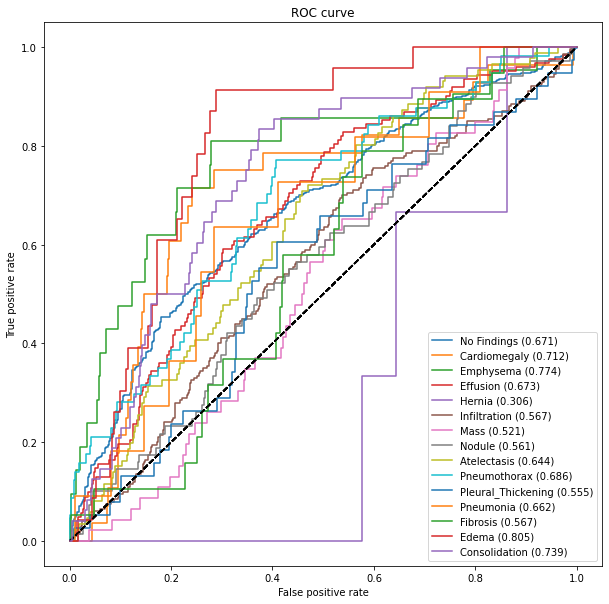

In [29]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, image_val)

In [30]:
mean_auroc = np.mean(auc_rocs)
print("Mean AUC: {}".format(mean_auroc))

Mean AUC: 0.629504932044633


In [31]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()
print(device)

<CUDA device 0 'b'NVIDIA GeForce RTX 2080 Ti''>


In [32]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import multilabel_confusion_matrix
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score

# start = time.time()
# y_prob = model_fusion.predict(image_val)
# end_test = time.time() - start

# y_pred = np.argmax(y_prob, axis=1)
# y_true = image_val.classes

# print("Precision:", precision_score(y_true, y_pred, average='weighted'), "Recall:", recall_score(y_true, y_pred, average='weighted'))

# cm = multilabel_confusion_matrix(y_true, y_pred)

# a = []

# for i in range(len(cm)):
#     a.append(cm[i].ravel())

# tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

# print("tp, fn, fp, tn:", tp, fn, fp, tn)

# print("Specificity:", tn / (tn+fp), "Sensitivity:", tp / (tp+fn))
# print("F1-Score:", f1_score(y_true, y_pred, average='weighted'), "Accuracy:", accuracy_score(y_true, y_pred))

# Specificty = tn / (tn+fp)
# Sensitivity = tp / (tp+fn)
# F1_Score = f1_score(y_true, y_pred, average='weighted')
# Accuracy = accuracy_score(y_true, y_pred)

In [33]:
# result = [y_true, y_pred]
# pd.DataFrame(result).to_csv("{}_{}_result.csv".format(model_name, n_fold))
# pd.DataFrame(y_prob).to_csv("{}_{}_probability.csv".format(model_name, n_fold))

In [34]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
# m_auc = roc_auc_score(y_true, y_pred)

# print(fpr_keras, tpr_keras, thresholds_keras, m_auc)

# from sklearn.metrics import auc
# auc_keras = auc(fpr_keras, tpr_keras)
# print(auc_keras)

In [35]:
# # keep probabilities for the positive outcome only
# lr_probs = y_prob[:, 1]
# lr_auc = roc_auc_score(y_true, lr_probs)
# print('Model Fusion: ROC AUC=%.3f' % (lr_auc))

# lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_probs)

# plt.figure(figsize=(10, 10))
# font={'size':'15'}
# plt.rc('font',**font)

# plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
# plt.plot(lr_fpr, lr_tpr, marker='.', label='{} Model ROC curve (area = %0.2f)'.format(model_name) % lr_auc)

# roc_auc = [lr_fpr, lr_fpr]
# pd.DataFrame(roc_auc).to_csv("{}_roc_auc.csv".format(model_name))

# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()

# AUC_Score = lr_auc

In [36]:
# Result = [Specificty, Sensitivity, F1_Score, Accuracy, AUC_Score, end_train, end_test, model_size, model_parameter]
# colname = ['Specificty', 'Sensitivity', 'F1_Score', 'Accuracy', 'AUC_Score', 'end_train', 'end_test', 'model_size', 'model_parameter']

# pd.DataFrame([Result], columns=colname).to_csv("{}_fold_".format(model_name)+str(n_fold)+".csv")

In [37]:
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 15))

# labels = ["Sperm", "Impurity"]
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# plt.rcParams['figure.figsize']=[15,15]
# font={'size':'30'}
# plt.rc('font',**font)
# disp.plot(cmap=plt.cm.Blues)